In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim

import helper_utils


torch.manual_seed(42) # consistent and reproducible results

# Machine Learning Pipeline
## 1) Data Ingestion and Preparation
Data ingestion means gathering raw data, meanwhile data prepartion means clean the data up.

Two tensors for this task:
- The distances tensor contains how far we biked for four recent deliveries (in miles).
- The times tensor shows how long each delivery took (in minutes).
- dtype=torch.float32 sets our data type to 32-bit floating point values for precise calculations.

In [2]:
# Distances in miles for recent deliveries 
distances = torch.tensor([[1.0], [2.0], [3.0], [4.0]], dtype=torch.float32)

# Corresponding del times in minutes
times = torch.tensor([[6.96], [12.11], [16.77], [22.21]])

## Stage 3: Model Building

For this scenario, we'll assume a linear relationship between distance and time. My model will be a single neuron that learns this relationship.

Single neuron:

<code>Time = W × Distance + B</code>

My job is to find the best values for the **weight (W)** and **bias (B)** that fit our delivery data.

- I will use <code>nn.[Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)(nn.[Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)(1, 1))</code> to create a linear model.
- `nn.Linear(1, 1)`: The first `1` means it takes one input (distance), and the second `1` means one neuron that is producing one output (predicted time).
- This single linear layer will automatically manage the weight and bias parameters for us.

In [3]:
model = nn.Sequential(nn.Linear(1, 1))

## Stage 4: Training
I need two key tools to help our model learn from the data:
- **Loss Function**: `nn.MSELoss` defines the Mean Squared Error loss function. It measures how wrong our predictions are. If I predict 25 minutes but the actual delivery took 30 minutes, the loss function quantifies that 5-minute error. The model's goal is to minimize this error.
- **Optimizer**: `optim.SGD` sets up the Stochastic Gradient Descent optimizer. It adjusts our model's weight and bias parameters based on the errors.
    * `lr=0.01`, This learning rate controls how big each adjustment step is. Too large and we might overshoot the best values; too small and training takes forever.

In [4]:
# Define loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Now it's time for our model to learn. The training loop is where our model cycles through the data repeatedly, gradually discovering the relationship between distance and delivery time.

I'll train for 500 epochs (complete passes through our data). During each epoch, these steps occur:
- `optimizer.zero_grad()`: Clears gradients from the previous round. Without this, PyTorch would accumulate adjustments, which could break the learning process.
- `outputs = model(distances)`: performs he "forward pass", where the model makes predictions based on the input `distances`.
- `loss = loss_function(outputs, times)`: Calculates how wrong the predicted `outputs` are by comparing them to the actual delivery `times`.
- `loss.backward()`: The "backward pass" (backpropagation) is performed, which calculates exactly how to adjust the weight and bias to reduce the error.
- `optimizer.step()`: Updates the model's parameters using those calculated adjustments.
- The loss is printed every 50 epochs to allow us to track the model's learning progress as the error decreases.

In [5]:
for epoch in range(500):
    # rest optimizer gradient
    optimizer.zero_grad()
    # make pred, forward pass
    outputs = model(distances)
    # calculate loss
    loss = loss_function(outputs, times)
    # calculate adjusment
    loss.backward()
    # update model's parameters
    optimizer.step()
    # print loss every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch + 1}: Loss = {loss.item()}')

Epoch 50: Loss = 0.03944866359233856
Epoch 100: Loss = 0.035811737179756165
Epoch 150: Loss = 0.0331188440322876
Epoch 200: Loss = 0.03112369030714035
Epoch 250: Loss = 0.029645616188645363
Epoch 300: Loss = 0.02855011820793152
Epoch 350: Loss = 0.0277385413646698
Epoch 400: Loss = 0.027137158438563347
Epoch 450: Loss = 0.026691725477576256
Epoch 500: Loss = 0.026361485943198204


### Visualizing the Training Results
Let's see what our model learned. By plotting the model's predictions as a line against our actual delivery data points, we can check if it found a good pattern.

The helper function, plot_results, will show us:
- Our original data points (actual deliveries)
- The line our model learned (its predictions)
- How well they match

In [8]:
print(distances)
print(times)

tensor([[1.],
        [2.],
        [3.],
        [4.]])
tensor([[ 6.9600],
        [12.1100],
        [16.7700],
        [22.2100]])


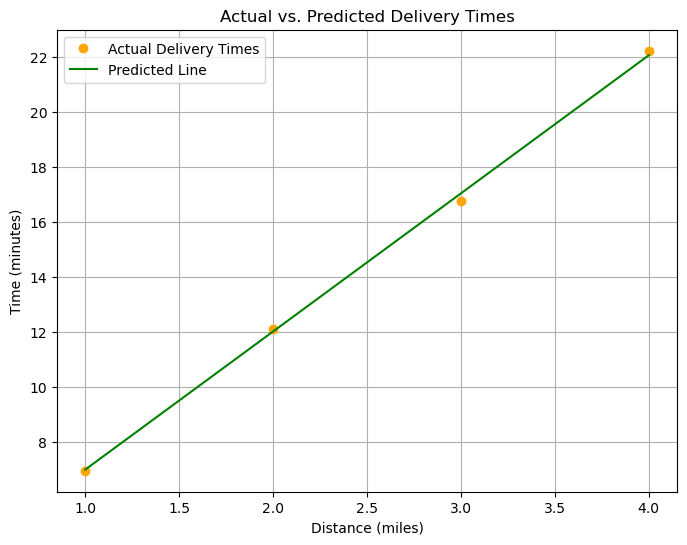

In [ ]:
helper_utils.plot_results(model, distances, times)

### Making Prediction
Our model is trained. Can we make that 7-mile delivery in under 30 minutes?

While a full evaluation would test the model on many unseen data points, here we'll jump straight to its intended purpose: making a data-driven prediction for a specific delivery.

- First, we'll set the `distance_to_predict` variable.
    * It is initially set to `7.0` to solve the original problem.
    * After running the code, we can easily come back and change this single variable to get predictions for any other distance.
- This variable is then used to create the input tensor for the model.

In [7]:
distances_to_predict = 7.0

* The entire prediction process is wrapped in a `with torch.no_grad()` block.
    * This tells PyTorch we're not training anymore, just making a prediction. This makes the process faster and more efficient.
* A new input tensor is created using the `distance_to_predict` variable.
    * This must be formatted as a 2D tensor (`[[7.0]]`), as the model expects this specific structure, not a simple number.
* Your trained `model` is called with this new tensor to generate a `predicted_time`.
* After getting the prediction (which is also a tensor), the code extracts the actual numerical value from it using `.item()`.

In [10]:
with torch.no_grad():
    # Convert the Python variable into a 2D PyTorch tensor that the model expects
    new_distance = torch.tensor([[distances_to_predict]], dtype=torch.float32)

    # pass new data to the trained model to get the pred
    predicted_time = model(new_distance)

    # use item to extract the scalar value from the tensor for printing
    print(f"Prediction for a {distances_to_predict}-mile delivery: {predicted_time.item():.1f} minutes")

    # Use the scalar value in a conditional statement to make the final decision
    if predicted_time.item() > 30:
        print("\nDecision: Do NOT take the job. You will likely be late.")
    else:
        print("\nDecision: Take the job. You can make it!")

Prediction for a 7.0-mile delivery: 37.1 minutes

Decision: Do NOT take the job. You will likely be late.


### Inspecting the Model's Learning
We have a working model and now we can see the exact relationship it learned from the data. We can do this by inspecting the model's internal parameters, the final weight and bias values it discovered during training. These values define the precise line your model is now using to make predictions.

In [13]:
# Access the layer in the sequential model
layer = model[0]

# Get weight and bias
weights = layer.weight.data.numpy()
bias = layer.bias.data.numpy()

print(f"Weight: {weights}")
print(f"Bias: {bias}")

Weight: [[5.015503]]
Bias: [1.9849645]


**Interpreting the Results**

These learned parameters have real-world meaning in the context of our problem:

* **Weight (~5.0)**: This means that for each additional mile, our model predicts the delivery time will increase by about 5.0 minutes.

* **Bias (~2.0)**: This represents the base time for any delivery, regardless of distance. We can think it as the time needed to pick up the order and get on our bike.

Our model has discovered a linear relationship between distance and time. With the **W** and **B** values it learned, it can now predict delivery times for any distance using the equation:

> <code>Time = 5.0 * Distance + 2.0</code>

### Testing Our Model on More Complex data
Our company is expanding its delivery services. To handle longer routes more efficiently, any delivery over 3 miles will now be made by car instead of bike.

That means our dataset just changed. It now includes a mix of bike and car deliveries, two different kinds of trips. We already have a model that worked well before. But will it still work now?

In [15]:
# short distances for bikes, longer distances for cars
new_distances = torch.tensor([
    [1.0], [1.5], [2.0], [2.5], [3.0], [3.5], [4.0], [4.5], [5.0], [5.5],
    [6.0], [6.5], [7.0], [7.5], [8.0], [8.5], [9.0], [9.5], [10.0], [10.5],
    [11.0], [11.5], [12.0], [12.5], [13.0], [13.5], [14.0], [14.5], [15.0], [15.5],
    [16.0], [16.5], [17.0], [17.5], [18.0], [18.5], [19.0], [19.5], [20.0]
], dtype=torch.float32)

# corresponding del times in minutes
new_times = torch.tensor([
    [6.96], [9.67], [12.11], [14.56], [16.77], [21.7], [26.52], [32.47], [37.15], [42.35],
    [46.1], [52.98], [57.76], [61.29], [66.15], [67.63], [69.45], [71.57], [72.8], [73.88],
    [76.34], [76.38], [78.34], [80.07], [81.86], [84.45], [83.98], [86.55], [88.33], [86.83],
    [89.24], [88.11], [88.16], [91.77], [92.27], [92.13], [90.73], [90.39], [92.98]
], dtype=torch.float32)

In [16]:
with torch.no_grad():
    predictions = model(new_distances)

Then:
- I'll Calculate the new_loss between the model's predictions and the actual times.
- Notice how the printed loss value will be significantly higher than the loss at the end of training. This will indicate a poor fit.

In [19]:
# Calculate new loss
new_loss = loss_function(predictions, new_times)
print(f"Loss on new, combined data: {new_loss.item():.2f}")

Loss on new, combined data: 179.26


To understand why the loss function is high, I'll visualize what is happening. 

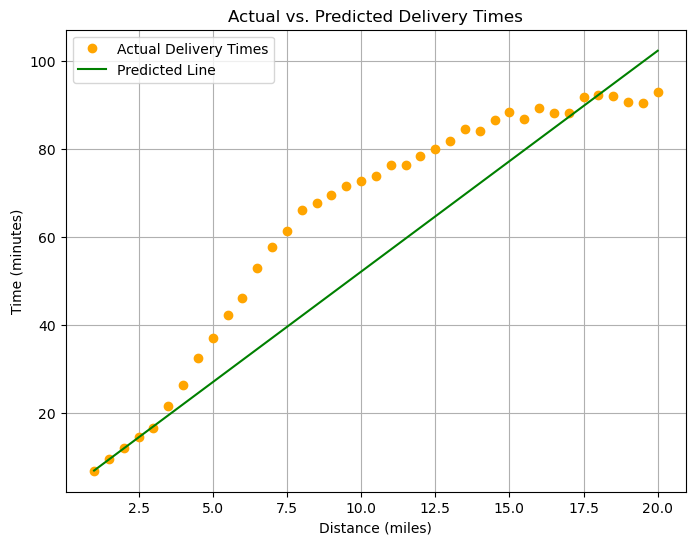

In [21]:
helper_utils.plot_results(model, new_distances, new_times)

<br>

**Why the linear model failed?**

Our model performed well on bike only data, where the relationship between distance and time was fairly consistent. But with the new dataset, things changed.

The loss is much higher and a quick look at the visualization showed why:

* **Actual Data (orange points)**: Delivery times follow a more complex pattern. Bikes take short, direct routes. Cars deal with city traffic, then speed up on highways. The relationship between distance and time isn’t smooth or consistent, it bends and shifts.
  
* **Model Predictions (green line)**: Our model can only draw a straight line. It learned one pattern: each mile adds about the same amount of time. But now that assumption no longer holds.

To capture these non-linear patterns, we need to give our model the ability to learn curves, not just lines. 